# T5 ASSIN
Tentando aplicar o T5 sobre o ASSIN.



In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Configuração e Imports


In [2]:
# Standard Libraries
import random
import pickle
import time
import sys
import psutil
import os
import gzip
from glob import glob
from argparse import Namespace
from multiprocessing import cpu_count
from collections import Counter
from typing import Sequence

# External Libraries
import torch
import numpy as np
import xmltodict

from matplotlib import pyplot as plt
from torch import Tensor, nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader
from torch.cuda import get_device_name
from sklearn.metrics import f1_score

# PyTorch Lightning and Transformer
import pytorch_lightning as pl
from transformers import T5Model, T5Tokenizer, PretrainedConfig
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer

%load_ext tensorboard

# Suppress some of the logging
import logging
logging.getLogger("transformers.configuration_utils").setLevel(logging.WARNING)
logging.getLogger("transformers.modeling_utils").setLevel(logging.WARNING)
logging.getLogger("transformers.tokenization_utils").setLevel(logging.WARNING)
logging.getLogger("lightning").setLevel(logging.WARNING)

import mlflow

print(f"\nImports loaded succesfully. Number of CPU cores: {cpu_count()}")


Imports loaded succesfully. Number of CPU cores: 12


## Classe Dataset
Gerenciamento dos dados, e um pequeno teste.

In [3]:
hparams = {"model_name": "ptt5-standard-vocab-small", "vocab_name": "t5-small", "seq_len": 128, "bs": 10, "reg": True, "version": 'v2'}


def prepare_data(file_name):
    '''
    Performs everything needed to get the data ready.
    Addition of Eos token and encoding is performed in runtime.
    '''
    folder = "assin_data"
    valid_modes = ["train", "validation", "test"]

    file_name = os.path.join(folder, file_name)
    if not os.path.isfile(file_name):
        print("Preprocessing data...")
        filenamesv1 = ['assin-ptbr-train.xml', 'assin-ptbr-dev.xml', 'assin-ptbr-test.xml']
        filenamesv2 = ['assin2-train-only.xml', 'assin2-dev.xml', 'assin2-test.xml']
        
        processed_data = {'v1': {mode: [] for mode in valid_modes},
                          'v2': {mode: [] for mode in valid_modes}}
        
        for mode, fnamev1, fnamev2 in zip(valid_modes, filenamesv1, filenamesv2):
            for v, fname in zip(['v1', 'v2'], [fnamev1, fnamev2]):
                with open(os.path.join(folder, fname), 'r') as xml:
                    xml_dict = xmltodict.parse(xml.read())
                    for data in xml_dict['entailment-corpus']['pair']:
                        processed_data[v][mode].append({"pair": (data['t'], data['h']), 
                                                        "similarity": float(data['@similarity']),
                                                        "entailment": data['@entailment']})

        with open(file_name, 'wb') as processed_file:
            pickle.dump(processed_data, processed_file)
        print("Done.")
    else:
        print(f"Processed data found in {file_name}.")
        with open(file_name, 'rb') as processed_file:
            processed_data = pickle.load(processed_file)

    return processed_data, valid_modes


class ASSIN(Dataset):
    '''
    Loads data from preprocessed file and manages them.
    '''
    CLASSES = ["None", "Entailment", "Paraphrase"]
    TOKENIZER = None
    DATA, VALID_MODES = prepare_data("processed_data.pkl")
    def __init__(self, version, mode, seq_len, reg, vocab_name):
        '''
        verison: v1 or v2
        mode: One of train, validation or test 
        seq_len: limit to returned encoded tokens
        '''
        ASSIN.TOKENIZER = T5Tokenizer.from_pretrained(vocab_name)
        super().__init__()
        assert mode in ASSIN.VALID_MODES

        self.seq_len = seq_len
        self.data = ASSIN.DATA[version][mode]
        self.reg = reg

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i: int):
        '''
        Unpacks line from data and applies T5 encoding if necessary.

        returns: input_ids, attention_mask, target (encoded if training)
        '''
        data = self.data[i]
        pair = data["pair"]
        if self.reg:
            target = torch.Tensor([data["similarity"]]).float().squeeze()
        else:
            target = torch.Tensor([ASSIN.CLASSES.index(data["entailment"])]).long().squeeze()

        eos_token = ASSIN.TOKENIZER.eos_token

        source = ASSIN.TOKENIZER.encode_plus(text=f"ASSIN sentence1: {pair[0]} {eos_token}", 
                                             text_pair=f"sentence2: {pair[1]} {eos_token}",
                                             max_length=self.seq_len, 
                                             pad_to_max_length=True, 
                                             return_tensors='pt')

        return source["input_ids"].squeeze(), source["attention_mask"].squeeze(), target

    def get_dataloader(self, batch_size: int, shuffle: bool):
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle, 
                          num_workers=4)

            
datasets = {m: ASSIN(version=hparams["version"], mode=m, seq_len=hparams["seq_len"], reg=hparams["reg"], 
                     vocab_name=hparams["vocab_name"]) for m in ASSIN.VALID_MODES}

# Testing datasets
for mode, dataset in datasets.items():
    print(f"\n{mode} dataset length: {len(dataset)}\n")
    print("Random sample")
    input_ids, attention_mask, target = random.choice(dataset)
    print(input_ids, attention_mask, target)

Processed data found in assin_data/processed_data.pkl.

train dataset length: 6500

Random sample
tensor([   71,  4256,  3162,  7142,   536,    10,   445,     2,    32,     3,
         3524,     3,    29,    35,  4884,     9,   158,     7,     7,    32,
            9,    16,    75,   989,    23,   232,    32,    38, 10541,   935,
            9,     7,     1,  7142,   357,    10,    71,   158,     7,     7,
           32,     9,   259,  2975,    16,    75,   989,    23,   232,    32,
           38, 10541,   935,     9,     7,     1,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,  

### Dataset Analysis

--------------- v1 stats --------------
Class balance: Counter({'None': 2331, 'Entailment': 529, 'Paraphrase': 140})
Similarity balance: Counter({4.0: 369, 2.5: 333, 2.75: 327, 2.25: 302, 3.0: 282, 3.25: 266, 3.75: 228, 2.0: 202, 3.5: 201, 1.75: 108, 4.25: 104, 5.0: 85, 1.5: 54, 4.75: 50, 4.5: 36, 1.25: 32, 1.0: 21})
{'total': 77632, 'mean': 25.877333333333333, 'std': 4.466723581726941, 'max': 42, 'min': 10}


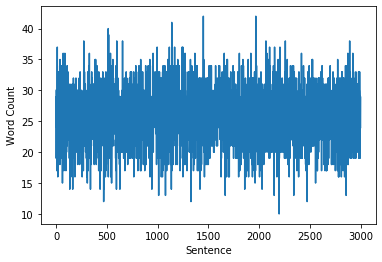

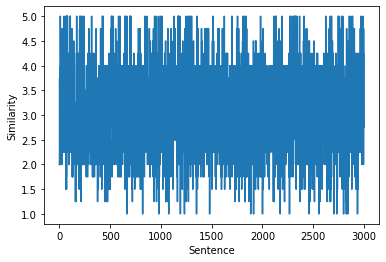

--------------- v2 stats --------------
Class balance: Counter({'Entailment': 3500, 'None': 3500})
Similarity balance: Counter({4.9: 701, 4.8: 558, 5.0: 474, 4.4: 380, 4.7: 374, 4.5: 369, 4.6: 355, 4.3: 276, 3.6: 222, 3.8: 216, 4.2: 209, 3.4: 193, 3.5: 183, 3.2: 181, 4.0: 180, 4.1: 178, 3.9: 173, 3.7: 154, 3.3: 149, 3.1: 146, 3.0: 129, 1.0: 122, 2.8: 110, 2.9: 85, 2.7: 82, 2.4: 79, 2.6: 76, 2.5: 60, 2.3: 58, 2.1: 46, 2.2: 36, 1.5: 30, 1.1: 30, 1.9: 28, 1.4: 26, 1.8: 24, 1.3: 24, 1.6: 22, 1.7: 20, 2.0: 18, 1.2: 14, 4.815: 9, 4.65: 7, 3.45: 6, 3.565: 6, 4.45: 5, 4.265: 5, 4.435: 5, 4.465: 4, 4.535: 4, 4.55: 4, 3.75: 4, 3.55: 4, 3.935: 4, 3.835: 4, 2.685: 4, 3.035: 4, 2.865: 4, 3.465: 4, 3.285: 4, 4.05: 4, 4.065: 3, 4.635: 3, 3.65: 3, 4.15: 3, 4.915: 2, 4.385: 2, 4.485: 2, 4.35: 2, 4.835: 2, 4.735: 2, 4.565: 2, 4.365: 2, 4.25: 2, 3.765: 2, 4.165: 2, 4.665: 2, 1.45: 2, 3.665: 2, 2.95: 2, 1.965: 2, 3.535: 2, 3.915: 2, 2.965: 2, 3.515: 2, 2.485: 2, 3.585: 2, 2.935: 2, 3.365: 2, 4.27: 2, 4.33

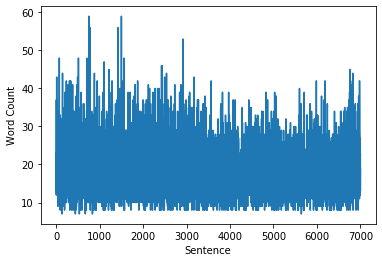

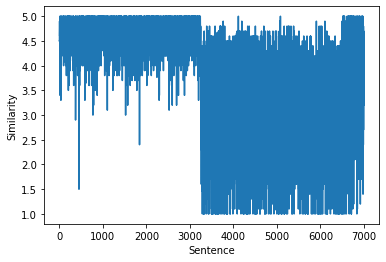

In [4]:
with open("assin_data/processed_data.pkl", 'rb') as processed_data_pkl:
    processed_data = pickle.load(processed_data_pkl)

for version in ['v1', 'v2']:
    wc = []
    classes = []
    regs = []

    for mode, data in processed_data[version].items():
        if mode == "test":
            continue

        for item in data:
            wc.append(len(item["pair"][0].split()) + len(item["pair"][1].split()))
            classes.append(item["entailment"])
            regs.append(item["similarity"])

    wc = np.array(wc)
    word_count_stats = {"total": wc.sum(),
                        "mean": wc.mean(),
                        "std": wc.std(),
                        "max": wc.max(),
                        "min": wc.min()}
    print(f"--------------- {version} stats --------------")
    print(f"Class balance: {Counter(classes)}")
    print(f"Similarity balance: {Counter(regs)}")

    print(word_count_stats)

    plt.xlabel("Sentence")
    plt.ylabel("Word Count")
    plt.plot(range(len(wc)), wc)
    plt.show()

    plt.xlabel("Sentence")
    plt.ylabel("Similarity")
    plt.plot(range(len(regs)), regs)
    plt.show()

## Dataloaders
Verificação se dataloaders estão funcionando corretamente.

In [ ]:
shuffle = {"train": True, "validation": False, "test": False}
debug_dataloaders = {mode: datasets[mode].get_dataloader(batch_size=hparams["bs"], 
                                                         shuffle=shuffle[mode])
                     for mode in ASSIN.VALID_MODES}

# Testing dataloaders
for mode, dataloader in debug_dataloaders.items():
    print("{} number of batches: {}".format(mode, len(dataloader)))
    batch = next(iter(dataloader))

train number of batches: 650
validation number of batches: 50
test number of batches: 245


## Radam

In [ ]:
if not os.path.isdir("RAdam"):
    !git clone https://github.com/LiyuanLucasLiu/RAdam
else:
    print("RAdam already downloaded.")
sys.path.append("RAdam")
from radam import RAdam

RAdam already downloaded.


## Lightning Module
Aqui a classe principal do PyTorch Lightning é definida. 

In [ ]:
CONFIG_PATH = "T5_configs_json"
CHECKPOINT_PATH = "/home/diedre/Dropbox/aUNICAMP/phd/courses/deep_learning_nlp/PTT5_data/checkpoints"


class NONLinearInput(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(nin, nout),
                                 nn.ReLU(),
                                 nn.Dropout(0.5))

    def forward(self, x):
        return 1 + self.net(x.float()).sigmoid()*4


class T5ASSIN(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()

        self.hparams = hparams

        if self.hparams.model_name[:2] == "pt":
            print("Initializing from PTT5 checkpoint")
            config, state_dict = self.get_ptt5()
            self.t5 = T5Model.from_pretrained(pretrained_model_name_or_path=None,
                                              config=config,
                                              state_dict=state_dict)
        else:
            self.t5 = T5Model.from_pretrained(hparams.model_name)

        D = self.t5.config.d_model

        if hparams.architecture == "mlp":
            # T5 is now a simple nonlinear input
            self.t5 = NONLinearInput(hparams.seq_len, D)
        
        if self.hparams.reg:
            self.linear = nn.Linear(D, 1)
        else:
            self.linear = nn.Linear(D, 3)
        

        if self.hparams.weight != None:
            self.weight = nn.Parameter(torch.Tensor(self.hparams.weight), requires_grad=False)
        else:
            self.weight = None

        if self.hparams.reg:
            self.loss = nn.MSELoss()
        else:
            self.loss = nn.CrossEntropyLoss(weight=self.weight)
        
    def get_ptt5(self):
        ckpt_paths = glob(os.path.join(CHECKPOINT_PATH, self.hparams.model_name + "*"))
        config_paths = glob(os.path.join(CONFIG_PATH, self.hparams.model_name + "*"))
        
        assert len(ckpt_paths) == 1 and len(config_paths) == 1, "Are the config/ckpts on the correct path?"

        config_path = config_paths[0]
        ckpt_path = ckpt_paths[0]

        config = PretrainedConfig.from_json_file(config_path)
        state_dict = torch.load(ckpt_path)
        return config, state_dict

    def forward(self, x):
        input_ids, attention_mask = x

        if self.hparams.architecture == "mlp":
            return self.linear(self.t5(input_ids))
        else:
            return 1 + self.linear(self.t5(input_ids=input_ids,
                                           decoder_input_ids=input_ids,
                                           attention_mask=attention_mask)[0].mean(dim=1)).sigmoid()*4

    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, y = batch
        x = (input_ids, attention_mask)
        y_hat = self(x).squeeze()
        loss = self.loss(y_hat, y)

        if self.hparams.reg:
            ret_dict = {'loss': loss}
        else:
            f1 = f1_score(y.view(-1).cpu().numpy(), y_hat.argmax(dim=-1).view(-1).detach().cpu().numpy(), 
                          average="macro")
            ret_dict = {'loss': loss, 'f1': f1}

        return ret_dict

    def validation_step(self, batch, batch_idx):
        input_ids, attention_mask, y = batch
        x = (input_ids, attention_mask)
        y_hat = self(x).squeeze()
        loss = self.loss(y_hat, y)

        if self.hparams.reg:
            ret_dict = {'loss': loss}
        else:
            f1 = f1_score(y.view(-1).cpu().numpy(), y_hat.argmax(dim=-1).view(-1).detach().cpu().numpy(), 
                          average="macro")
            ret_dict = {'loss': loss, 'f1': f1}

        return ret_dict

    def test_step(self, batch, batch_idx):
        input_ids, attention_mask, y = batch
        x = (input_ids, attention_mask)
        y_hat = self(x).squeeze()
        loss = self.loss(y_hat, y)

        if self.hparams.reg:
            ret_dict = {'loss': loss}
        else:
            f1 = f1_score(y.view(-1).cpu().numpy(), y_hat.argmax(dim=-1).view(-1).detach().cpu().numpy(), 
                          average="macro")
            ret_dict = {'loss': loss, 'f1': f1}

        return ret_dict

    def training_epoch_end(self, outputs):
        name = "train_"

        loss = torch.stack([x['loss'] for x in outputs]).mean()

        if self.hparams.reg:
            logs = {name + "loss": loss}
        else:
            f1 = np.array([x['f1'] for x in outputs]).mean()
            logs = {name + "loss": loss, 
                    name + "f1": f1}
                
        return {name + 'loss': loss, 'log': logs, 'progress_bar': logs}

    def validation_epoch_end(self, outputs):
        name = "val_"

        loss = torch.stack([x['loss'] for x in outputs]).mean()

        if self.hparams.reg:
            logs = {name + "loss": loss}
        else:
            f1 = np.array([x['f1'] for x in outputs]).mean()
            logs = {name + "loss": loss, 
                    name + "f1": f1}
                
        return {name + 'loss': loss, 'log': logs, 'progress_bar': logs}

    def test_epoch_end(self, outputs):
        name = "test_"

        loss = torch.stack([x['loss'] for x in outputs]).mean()

        if self.hparams.reg:
            logs = {name + "loss": loss}
        else:
            f1 = np.array([x['f1'] for x in outputs]).mean()
            logs = {name + "loss": loss, 
                    name + "f1": f1}
                
        return {name + 'loss': loss, 'log': logs, 'progress_bar': logs}

    def configure_optimizers(self):
        return RAdam(self.parameters(), lr=self.hparams.lr)    

    def train_dataloader(self):
        if self.hparams.overfit_pct > 0:
            logging.info("Disabling train shuffle due to overfit_pct.")
            shuffle = False
        else:
            shuffle = True
        dataset = ASSIN(mode="train", version=self.hparams.version, seq_len=self.hparams.seq_len, reg=self.hparams.reg, 
                        vocab_name=self.hparams.vocab_name)
        return dataset.get_dataloader(batch_size=self.hparams.bs, shuffle=shuffle)

    def val_dataloader(self):
        dataset = ASSIN(mode="validation", version=self.hparams.version, seq_len=self.hparams.seq_len, reg=self.hparams.reg, 
                        vocab_name=self.hparams.vocab_name)
        return dataset.get_dataloader(batch_size=self.hparams.bs, shuffle=False)
    
    def test_dataloader(self):
        dataset = ASSIN(mode="test", version=self.hparams.version, seq_len=self.hparams.seq_len, reg=self.hparams.reg, 
                        vocab_name=self.hparams.vocab_name)
        return dataset.get_dataloader(batch_size=self.hparams.bs, shuffle=False)


# Initialization test
# hparams.update({"architecture": "ptt5", "weight": None})
# T5ASSIN(Namespace(**hparams))

## Preparação Treino

In [ ]:
%tensorboard --logdir /home/diedre/Dropbox/aUNICAMP/phd/courses/deep_learning_nlp/PTT5_data/logs

Reusing TensorBoard on port 6006 (pid 27504), started 0:27:44 ago. (Use '!kill 27504' to kill it.)

/usr/local/lib/python3.6/dist-packages/tensorboard/notebook.py:383: DeprecationWarning: cgi.escape is deprecated, use html.escape instead
  ("%HTML_ID%", cgi.escape(frame_id, quote=True)),


## Hparams

In [ ]:
hparams = {"name": "assin2_t5_small",
           "model_name": "t5-small",  # which weights to start with
           "vocab_name": "t5-small",  # which vocab to use
           "seq_len": 128,
           "version": 'v2',
           "lr": 0.0001, "bs": 32, "architecture": "t5", 
           "max_epochs": 20, "precision": 32,
           "overfit_pct": 0, "debug": 0,
           "weight": None, "reg": True}

# 6 GB VRAM BS, 32 precision:
## small- 32
## base- 2

for key, parameter in hparams.items():
    print("{}: {}".format(key, parameter))

name: assin2_t5_small
model_name: t5-small
vocab_name: t5-small
seq_len: 128
version: v2
lr: 0.0001
bs: 32
architecture: t5
max_epochs: 20
precision: 32
overfit_pct: 0
debug: 0
weight: None
reg: True


In [ ]:
# Instantiate model
model = T5ASSIN(Namespace(**hparams))

log_path = "/home/diedre/Dropbox/aUNICAMP/phd/courses/deep_learning_nlp/PTT5_data/logs"
model_path = "/home/diedre/Dropbox/aUNICAMP/phd/courses/deep_learning_nlp/PTT5_data/models"

# Folder/path management, for logs and checkpoints
experiment_name = hparams["name"]
model_folder = os.path.join(model_path, experiment_name)
os.makedirs(model_folder, exist_ok=True)

if hparams["reg"]:
    ckpt_path = os.path.join(model_folder, "-{epoch}-{val_loss:.2f}")
else:
    ckpt_path = os.path.join(model_folder, "-{epoch}-{val_f1:.2f}")

# Callback initialization
checkpoint_callback = ModelCheckpoint(prefix=experiment_name, 
                                      filepath=ckpt_path, 
                                      monitor="val_loss", 
                                      mode="min")

logger = TensorBoardLogger(log_path, experiment_name)

# PL Trainer initialization
trainer = Trainer(gpus=1, 
                  precision=hparams["precision"], 
                  checkpoint_callback=checkpoint_callback, 
                  early_stop_callback=False,
                  logger=logger,
                  max_epochs=hparams["max_epochs"], 
                  fast_dev_run=bool(hparams["debug"]), 
                  overfit_pct=hparams["overfit_pct"],
                  progress_bar_refresh_rate=1,
                  profiler=True)

No environment variable for node rank defined. Set as 0.


## Treino

In [ ]:
trainer.fit(model)

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)


# Teste
Teste só foi olhado depois de escolher hiperparâmetros.

In [ ]:
'''models = glob(os.path.join(model_path, experiment_name, "*.ckpt"))
print(f"Loading {models}")
assert len(models) == 1

best_model = T5ASSIN.load_from_checkpoint(models[0])'''

In [ ]:
'''trainer.test(best_model)'''